# Shopify Data Science Intern Challenge - Fall 2021

This notebook shows my solutions to the Shopify Data Science Intern Challenge for Fall 2021.

All of the libraries that will be necessary for the analysis are imported below.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## 1. (a)

In this first portion of the analysis, we would like to investigate why the average order value (AOV) for sneaker stores has been calculated at $3145.13 when sneakers are a relatively affordable item. Additionally, we would like to determine a better way for evaluating the AOV.

To begin, let's read in the data and do some basic data exploration.

In [2]:
shops = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv', parse_dates=['created_at'])
shops.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


In [3]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        5000 non-null   int64         
 1   shop_id         5000 non-null   int64         
 2   user_id         5000 non-null   int64         
 3   order_amount    5000 non-null   int64         
 4   total_items     5000 non-null   int64         
 5   payment_method  5000 non-null   object        
 6   created_at      5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 254.0+ KB


It looks like the dataset is already clean and the columns are fairly easy to understand:
* `order_id`: A unique identifier used to reference each transaction.
* `shop_id`: A unique identifier used to reference each online shop.
* `user_id`: A unique identifier used to reference each online customer. Note: It's not clear whether identical user_ids are the same person between different stores.
* `order_amount`: The amount that was spent in a given transaction.
* `total_items`: The total number of items purchased in a given transaction.
* `payment_method`: The method of payment used.
* `created_at`: The time and date when the transaction occured.

Before we continue our data exploration, let's confirm that we get the same AOV that was previously calculated.

In [4]:
AOV_mean = round(shops['order_amount'].mean(), 2)
print(AOV_mean)

3145.13


Let's also verify that the time period falls within a month, in case a transaction outside of this time range accidentally made its way into the dataset.

In [5]:
period = shops['created_at'].max() - shops['created_at'].min()
print(period)

29 days 23:47:26


Excellent. Now the most likely cause of an unexpectedly high average is the inclusion of outliers or anomalous data points within the dataset. To examine whether such points exist in the dataset, we can look at the frequency distribution of the number of items sold per transaction.

In [6]:
# Count the frequency of occurence for the number of items purchased in a transaction:
total_items_counts = shops['total_items'].value_counts()
total_items_count = total_items_counts.reset_index()
total_items_count.rename(columns={"index": "Number of Items Sold", "total_items": "Frequency of Occurrence"}, inplace=True)
total_items_count.sort_values('Number of Items Sold', inplace=True)

Text(0.5, 1.0, 'Frequency Distribution of the Number of Items Sold per Transaction')

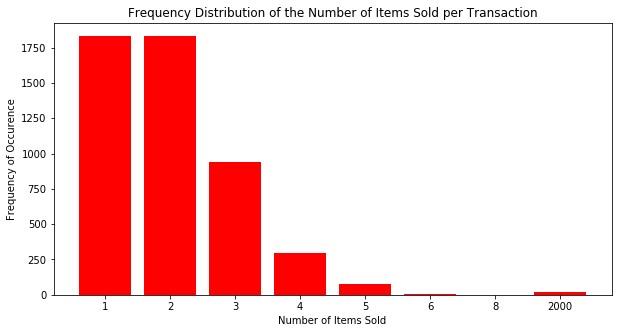

In [7]:
# Plot distribution of frequencies:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x=total_items_count['Number of Items Sold'].astype('str'), height=total_items_count['Frequency of Occurrence'], color='red')
ax.set_xlabel('Number of Items Sold')
ax.set_ylabel('Frequency of Occurence')
ax.set_title('Frequency Distribution of the Number of Items Sold per Transaction')

The bar plot above indicates that there may be some anomalies in the data. The critieria that will be used for labelling data points as anomalies will be: a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile [https://mathworld.wolfram.com/Outlier.html]. The code below accomplishes this.

In [8]:
def find_outliers(value, data):
    """
    Determines whether a data point in a series of data is anomalous / an outlier.
    
    Arguments:
    value -- Data point being evaluated.
    data -- Data series used to determine if value is an outlier.
   
    Returns: 
    outlier -- True/False, True indicating that value is an outlier and False indicating that it is not.
    """
    data = pd.Series(data)
    first_quart = data.quantile(0.25)
    third_quart = data.quantile(0.75)
    interquart_range = third_quart - first_quart
    
    upper_lim = third_quart + 1.5 * interquart_range
    lower_lim = first_quart - 1.5 * interquart_range
    
    if (value < lower_lim) or (value > upper_lim):
        outlier = True
    else:
        outlier = False
        
    return outlier

In [9]:
item_outliers_mask = shops.apply(lambda x: find_outliers(x['total_items'], shops['total_items']), axis=1)

In [10]:
item_anomalies = shops.loc[item_outliers_mask, "total_items"].value_counts().sum()
print("There are " + str(item_anomalies) + " anomalous data points with regard to number of items purchased per transaction.")

There are 18 anomalous data points with regard to number of items purchased per transaction.


As suspected, a number of the purchases were labelled as being anomalous. **These anomalous data points are likely to be the cause of the artificially high AOV**. There are two approaches that we can take in re-evaluating the AOV given this scenario: 

1. We remove the anomalous data from the analysis and re-calculate the AOV based on the remaining dataset. This would be a "low volume" AOV.
2. Calculate the AOV using the median instead of the mean. This may actually be a more suitable alternative (even if the anamolus data points weren't present) because it indicates the value that separates the upper and lower halves of the distribution. The other benefit to this approach is that we can still use all of the data, instead of removing data points.

We will proceed with the second approach given its previously stated advantages.

In [11]:
AOV_median = shops['order_amount'].median()
print("The median AOV is $" + str(AOV_median) + ".")

The median AOV is $284.0.


By taking calculating the **AOV using the median instead of the mean**, we find an AOV of **$284.00** which is more representative of the price of sneakers.

## 1. (b) & (c)

In this part of the analysis, we would like to determine what aggragate metric will best help merchants understand how their businesses are performing when compared to the rest of the market, and to provide values for those metrics. Because the dataset is rich with information, in addition to the newly calculated AOV above, we can create a suite of metrics that can serve this purpose, which include:

* Average price per item - tells us what the market value of an item is.
* Average repeat customer rate - gives us an indication of how consistent income may be in the future (easier to convert existing customers), as well as the potential market for converting new customers.
* Average number of items sold per transaction - provides a baseline as to how many items are typically sold in a transaction.

To start, let's take a look at the average price per item. In this case we will consider the average price at the product level, rather than the individual transaction level. We will assume that each store sells a unique product which is different from every other store. Because stores may provide discounts and other offers, the price of an item will be represented as the mean value of all transactions for a given store.

In [12]:
shops['price_per_item'] = shops['order_amount'] / shops['total_items']

# Extract the item price from each store:
item_prices = []
for shop in shops['shop_id'].unique():
    item_price = shops.loc[shops['shop_id'] == shop, 'price_per_item'].mean()
    item_prices.append(float(item_price))
    
# Use the item prices from each store to calculate the average price of items available:
avg_item_price = np.mean(item_prices)
print("The average (mean) price per item is $" + str(avg_item_price) + ".")

The average (mean) price per item is $407.99.


Although this is not impossible, we do not expect the average price of an item to exceed the AOV, given that the AOV represents aggragated points from transactions with more than one item. Given this unexpected discrepancy, we should take a look at the distribution of item prices to inspect whether there are any anomalous values included in the dataset.

Text(0.5, 1.0, 'Frequency Distribution of Sneaker Prices')

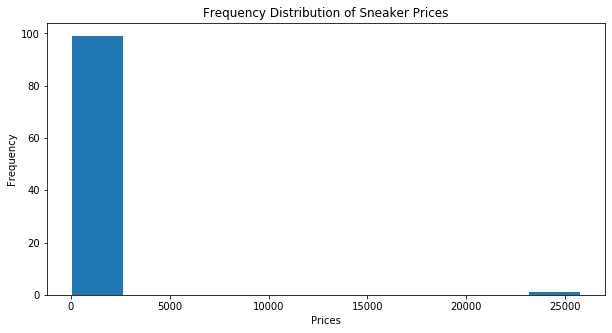

In [13]:
fig = plt.figure(figsize=(10,5))
plt.hist(item_prices)
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Sneaker Prices')

The histogram above indicates that there may be anomalies in this dataset. To confirm this, we can use the `find_outliers` function from 1. (a).

In [14]:
item_price_outliers = [find_outliers(x, item_prices) for x in item_prices]
item_price_anomalies = pd.Series(item_prices)[item_price_outliers].value_counts().sum()
print("There are " + str(item_price_anomalies) + " anomalous data points with regard to price of an item.")

There are 2 anomalous data points with regard to price of an item.


These two anomalous data points are likely the cause of the high average price of an item. To overcome this inflation effect, we can use the median instead of the mean, like we did with the AOV in 1. (a).

In [15]:
med_avg_item_price = np.median(item_prices)
print("The average (median) price per item is $" + str(med_avg_item_price) + ".")

The average (median) price per item is $153.0.


The median price of an item is therefore **$153.00**.

Next, we will look at the average repeat customer rate. In order to be considered a repeat customer, an individual must make at least two transactions at the same store. In this case, an individual can be considered a repeat customer more than once if they make multiple purchases at different stores. The value calculated will be a macro-average, this way store owners can understand how their RCR compares to other stores, rather than the market as a whole.

In [16]:
repeat_customer_rates = []
for shop in shops['shop_id'].unique():
    shop_df = shops[shops['shop_id'] == shop]
    repeat_customers = 0
    customer_cache = []
    for _, row in shop_df.iterrows():
        customer = row['user_id']
        if customer not in customer_cache:
            customer_cache.append(customer)
            customer_instances = shop_df[shops['user_id'] == customer].shape[0]
            if customer_instances > 1:
                repeat_customers += 1
    repeat_customer_rate = repeat_customers / shop_df.shape[0]
    repeat_customer_rates.append(repeat_customer_rate)

C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [17]:
macro_avg_RCR = round(100*np.mean(repeat_customer_rates), 2)
print("The macro-average repeat customer rate is " + str(macro_avg_RCR) + "%.")

The macro-average repeat customer rate is 7.05%.


Therefore, the macro-average repeat customer rate is **7.05%**.

Finally, we will look at the average number of items sold per transaction. In this case, we are most interested in the number of items that are most frequently purchased. The best method for averaging in this case is to use the mode.

In [18]:
average_items_sold = shops['total_items'].mode()[0]
print("The modal average of items sold per transaction is " + str(average_items_sold) + ".")

The modal average of items sold per transaction is 2.


Therefore, the modal average of items sold per transaction is **2**.

A summary of the metrics and corresponding values used to report on this dataset are as follows:

* Average Order Value (AOV) (Median): **\$284.00** 
* Average Price per Item (Median): **\$153.00**
* Average Repeat Customer Rate (Macro-Average): **7.05%**
* Average Items Sold per Transaction (Mode): **2**

## 2 (a)

`SELECT COUNT(ShipperID) 
   FROM Orders
  WHERE ShipperID = (SELECT ShipperID 
			           FROM Shippers
			          WHERE ShipperName = "Speedy Express");`

The number of orders shipped by Speed Express is **54**.

## 2 (b)

  `SELECT TOP 1 e.LastName
     FROM Orders AS o
LEFT JOIN Employees AS e ON o.EmployeeID = e.EmployeeID
 GROUP BY e.LastName
 ORDER BY COUNT(e.LastName) DESC;`

The last name of the employee with the most orders is **Peacock**.

## 2 (c)

 `SELECT TOP 1 p.ProductName 
    FROM (((OrderDetails AS od
		   LEFT JOIN
			    Orders AS o ON od.OrderID = o.OrderID)
		   LEFT JOIN 
			    Products AS p ON od.ProductID = p.ProductID)
           LEFT JOIN
        	    Customers AS c ON o.CustomerID = c.CustomerID)
   WHERE c.Country = "Germany"
GROUP BY p.ProductName
ORDER BY SUM(od.Quantity) DESC;`

The most ordered product from customers in Germany is **Boston Crab Meat**.
